In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import talib
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import yfinance as yf

from IPython.display import clear_output

%matplotlib inline

pd.set_option('display.max_columns', None)

# Подготовка данных

In [118]:
def fill_missing_values(data):
    """
    Функция заполняет пропущенные значения в DataFrame предыдущими значениями 
    и удаляет дубликаты по индексу.
    """
    df = data.copy()

    # Проверка и удаление дубликатов по индексу
    if df.index.duplicated().any():
        print("Обнаружены дубликаты по индексу. Они будут удалены.")
        df = df[~df.index.duplicated(keep='first')]
    else:
        print("Дубликатов не обнаружено.")

    # Проверка на наличие пропущенных значений
    if df.isnull().any().any():
        print("Обнаружены пропущенные значения. Выполняется заполнение предыдущими значениями...")
        # Заполняем пропущенные значения предыдущими
        df = df.fillna(method='ffill')
        
        # Если в начале есть NaN, заполняем их последующими значениями
        df = df.fillna(method='bfill')
    else:
        print("Пропущенные значения отсутствуют.")

    return df

In [119]:
# Функция для добавления лагов

def add_lags(data, columns, lags):
    """Функция для добавления лагов

    Args:
        data (pd.Dataframe): pandas Dataframe с данными по активу
        columns (List): список колонорк для расчета лагов
        lags (List): список шагов назад для расчета лагов
    """
    df = data.copy()

    for lag in lags: # Добавляем лаги по шагам назад из lags
        for column in columns:
            new_col_name = f'{column}_lag_{lag}'
            df[new_col_name] = df[column].shift(lag)
    
    return df

In [120]:
# Функция для добавления индикаторов

def add_indicators(data, columns, windows_SMA, windows_RSI):
    """Функция для добавления индикаторов SMA и RSI

    Args:
        data (pd.Dataframe): pandas Dataframe с данными по активу
        columns (List): список колонорк для расчета индикаторов
        windows_SMA (List): список окон для расчета MA
        windows_RSI (List): список окон для расчета RSI
    """
    df = data.copy()

    for window in windows_SMA: # Расчитываем и добавляем SMA по указанным колонкам
        for column in columns:
            new_col_name = f'{column}_SMA_{window}'
            df[new_col_name] = df[column].rolling(window).mean()

    for window in windows_RSI: # Расчитываем и добавляем RSI по указанным колонкам
        for column in columns:
            new_col_name = f'{column}_RSI_{window}'
            df[new_col_name] = talib.RSI(df[column], timeperiod=window)
    
    return df

In [121]:
# Функция для добавления статистик

def add_stats_features(data, columns, windows):
    """Функция для добавления статистик, min, max, std за периоды windows

    Args:
        data (pd.Dataframe): pandas Dataframe с данными по активу
        columns (List): список колонорк для расчета статистик
        windows (List): список окон для расчета статистик
    """   
    df = data.copy()

    for column in columns:
        for window in windows:
            # Скользящее среднее
            df[f'{column}_mean_{window}'] = df[column].rolling(window=window).mean()
            
            # Скользящая медиана
            df[f'{column}_median_{window}'] = df[column].rolling(window=window).median()
            
            # Скользящий минимум
            df[f'{column}_min_{window}'] = df[column].rolling(window=window).min()
            
            # Скользящий максимум
            df[f'{column}_max_{window}'] = df[column].rolling(window=window).max()
            
            # Скользящее стандартное отклонение
            df[f'{column}_std_{window}'] = df[column].rolling(window=window).std()
            
            # Скользящий размах (макс - мин)
            df[f'{column}_range_{window}'] = df[f'{column}_max_{window}'] - df[f'{column}_min_{window}']

    return df

In [122]:
# Функция для добавления разницы между higt и low

def add_hight_low_dif(data):
    df = data.copy()
    df['High-Low'] = df['High'] - df['Low']
    return df

In [123]:
# Функция для добавления трендовых фичей

def add_trend_feat(data, columns, windows):
    """Функция для трендовых фичей

    Args:
        data (pd.Dataframe): pandas Dataframe с данными по активу
        columns (List): список колонорк трендовых фичей
        windows (List): список окон трендовых фичей
    """   
    df = data.copy()
    for column in columns:
        for window in windows:
            # Отношение текущего значения к предыдущему (лаг = 1)
            df[f'{column}_ratio_1'] = df[column] / df[column].shift(1)
            
            # Логарифмическое изменение (логарифм отношения текущего значения к предыдущему)
            df[f'{column}_log_diff_1'] = np.log(df[column] / df[column].shift(1))
            
            # Momentum (разница между текущим значением и значением N периодов назад)
            df[f'{column}_momentum_{window}'] = df[column] - df[column].shift(window)
            
            # Rate of Change (ROC): процентное изменение за N периодов
            df[f'{column}_roc_{window}'] = (df[column] - df[column].shift(window)) / df[column].shift(window) * 100
    
    return df    

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import pickle

# Функция для нормализации данных

def normalize_dataframe(data, scaler="StandardScaler", save_scaler=True, scaler_file="scaler.pkl"):
    """Функция нормализует DataFrame с использованием заданного скейлера.

    Args:
    df (pd.DataFrame): Датафрейм для нормализации.
    scaler (str or sklearn Scaler): Имя скейлера ("StandardScaler", "MinMaxScaler", "RobustScaler") 
                                     или уже обученный объект скейлера.
    save_scaler (bool): сохранять ли scaler в файл (по умолчанию: сохранять)
    scaler_file (str): Имя файла, куда сохраняется обученный скейлер (по умолчанию: "scaler.pkl").

    """
    df = data.copy()

    if isinstance(scaler, str):
        # Создаем скейлер на основе переданного имени
        if scaler == "StandardScaler":
            scaler = StandardScaler()
        elif scaler == "MinMaxScaler":
            scaler = MinMaxScaler()
        elif scaler == "RobustScaler":
            scaler = RobustScaler()
        else:
            raise ValueError(f"Неизвестный скейлер: {scaler}")

        # Обучаем скейлер на датафрейме
        scaler.fit(df)

        # Сохраняем обученный скейлер в файл
        if save_scaler:
            with open(scaler_file, "wb") as f:
                pickle.dump(scaler, f)
    elif hasattr(scaler, "transform"):
        # Если передан обученный скейлер, просто используем его
        pass
    else:
        raise ValueError("Передан некорректный скейлер. Должна быть строка 'StandardScaler', 'MinMaxScaler', 'RobustScaler' или объект sklearn Scaler.")

    # Применяем скейлер к датафрейму
    normalized_data = scaler.transform(df)

    # Возвращаем нормализованный датафрейм и обученный скейлер
    return pd.DataFrame(normalized_data, columns=df.columns, index=df.index), scaler

In [9]:
# Функция для загрузки скейлера из файла
def load_scaler(scaler_file):
    """Загружает скейлер из указанного файла.

    Args:
    scaler_file (str): Путь к файлу, содержащему сохранённый скейлер.

    Return:
    sklearn Scaler: Загруженный объект скейлера.
    """
    with open(scaler_file, "rb") as f:
        scaler = pickle.load(f)
    return scaler

In [10]:
# Функция для добавления номеров месяцев, дней, часов

def add_datetime_features(data, add_month=True, add_weekday=True, add_hour=True):
    """Функция добавляет в DataFrame столбцы с номером месяца, дня недели и часа из индекса Datetime.
    
    Args:
    df (pd.DataFrame): DataFrame с индексом типа Datetime.
    add_month (bool): Добавлять ли столбец с номером месяца (1-12).
    add_weekday (bool): Добавлять ли столбец с номером дня недели (0 - понедельник, 6 - воскресенье).
    add_hour (bool): Добавлять ли столбец с номером часа (0-23).
    """
    df = data.copy()
    
    # Добавляем столбцы по выбору
    if add_month:
        df['Month'] = df.index.month
    if add_weekday:
        df['Weekday'] = df.index.weekday
    if add_hour:
        df['Hour'] = df.index.hour
    
    return df

## Итоговая функция для подготовки данных

In [124]:
def prepare_date(data, 
                 lags, 
                 windows_SMA, 
                 windows_RSI, 
                 windows_stats, 
                 windows_trend, 
                 add_month=True, 
                 add_weekday=True, 
                 add_hour=True):
    """
    Функция для добавления фичей и нормализации

    Args:
        data (pd.DataFrame): DataFrame с индексом типа Datetime.
        windows_SMA (List): список окон для индикатора SMA.
        windows_RSI (List): список окон для индикатора RSI.
        windows_stats (List): список окон для статистических фичей.
        windows_trend (List): список окон для трендовых фичей.
        add_month (bool): Добавлять ли столбец с номером месяца (1-12).
        add_weekday (bool): Добавлять ли столбец с номером дня недели (0 - понедельник, 6 - воскресенье).
        add_hour (bool): Добавлять ли столбец с номером часа (0-23).
    """

    df = data.copy()
    columns = df.columns

    df = fill_missing_values(df)
    df = add_lags(df, columns=columns, lags=lags)
    df = add_indicators(df, columns=['Close'], windows_SMA=windows_SMA, windows_RSI=windows_RSI)
    df = add_stats_features(df, columns=['Close'], windows=windows_stats)
    df = add_hight_low_dif(df)
    df = add_trend_feat(df, columns=['Close'], windows=windows_trend)
    df = add_datetime_features(df, add_month=add_month, add_weekday=True, add_hour=True)
    df = df.dropna()

    return df

In [125]:
# Посмотрим на работу функции

# Период для загрузки данных
start = '2023-12-10'
end = '2024-12-10'

btc_df = yf.download("BTC-USD", start=start, end=end, interval='1h', multi_level_index=False)

[*********************100%***********************]  1 of 1 completed


In [126]:
btc_df

,Adj Close,Close,High,Low,Open,Volume
Datetime,,,,,,
2023-12-10 00:00:00+00:00,43787.191406,43787.191406,43796.824219,43698.183594,43728.382812,0
2023-12-10 01:00:00+00:00,43798.429688,43798.429688,43865.984375,43740.445312,43784.937500,0
2023-12-10 02:00:00+00:00,43749.144531,43749.144531,43821.683594,43729.355469,43799.656250,0
2023-12-10 03:00:00+00:00,43848.250000,43848.250000,43848.250000,43738.503906,43749.660156,0
2023-12-10 04:00:00+00:00,43942.453125,43942.453125,43955.914062,43833.082031,43850.214844,0
...,...,...,...,...,...,...
2024-12-09 19:00:00+00:00,97000.070312,97000.070312,97779.671875,96980.539062,97779.671875,2891431936
2024-12-09 20:00:00+00:00,96149.820312,96149.820312,97236.070312,96146.187500,96990.710938,5003141120
2024-12-09 21:00:00+00:00,97234.968750,97234.968750,97474.546875,95042.921875,96220.375000,10950115328


In [127]:
btc_df.describe()

,Adj Close,Close,High,Low,Open,Volume
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8.784000e+03
mean,62551.447117,62551.447117,62747.585620,62339.097014,62545.258640,3.719760e+08
std,13133.071474,13133.071474,13177.607744,13079.394099,13128.623196,8.278924e+08
min,38754.246094,38754.246094,38834.503906,38521.894531,38740.496094,0.000000e+00
25%,56953.037109,56953.037109,57213.345703,56721.973633,56967.307617,0.000000e+00
50%,63207.554688,63207.554688,63422.787109,62991.476562,63208.085938,0.000000e+00
75%,67808.896484,67808.896484,68010.667969,67635.345703,67805.292969,4.075776e+08
max,103500.882812,103500.882812,103565.882812,102821.945312,103502.289062,1.364496e+10


In [128]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2023-12-10 00:00:00+00:00 to 2024-12-09 23:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  8784 non-null   float64
 1   Close      8784 non-null   float64
 2   High       8784 non-null   float64
 3   Low        8784 non-null   float64
 4   Open       8784 non-null   float64
 5   Volume     8784 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 480.4 KB


<Axes: xlabel='Datetime'>

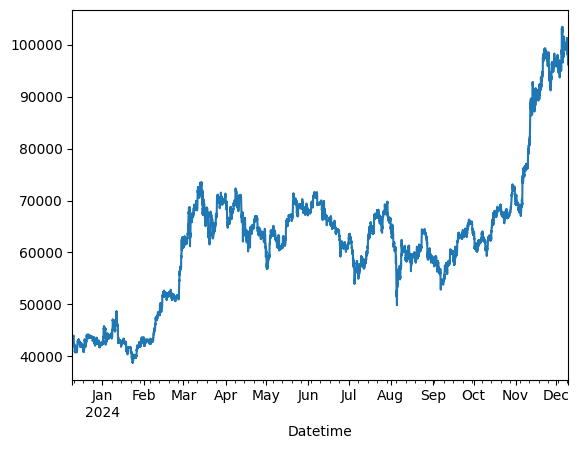

In [129]:
btc_df['Close'].plot()

In [130]:
window_lag = [3, 9]
window_SMA = [6, 20]
window_RSI = [4, 9]
windows_stats = [3, 20]
windows_trend = [3, 20]

btc_df_features = prepare_date(btc_df, lags=window_lag, windows_SMA=window_SMA, windows_RSI=window_RSI, windows_stats=windows_stats, windows_trend=windows_trend)

Дубликатов не обнаружено.
Пропущенные значения отсутствуют.


In [131]:
btc_df_features

,Adj Close,Close,High,Low,Open,Volume,Adj Close_lag_3,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Adj Close_lag_9,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_SMA_6,Close_SMA_20,Close_RSI_4,Close_RSI_9,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_20,Close_median_20,Close_min_20,Close_max_20,Close_std_20,Close_range_20,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_20,Close_roc_20,Month,Weekday,Hour
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-10 20:00:00+00:00,43959.230469,43959.230469,43968.097656,43788.921875,43798.453125,14036992,43816.816406,43816.816406,43844.542969,43773.738281,43830.941406,0.000000e+00,43748.679688,43748.679688,43758.929688,43696.523438,43707.359375,0.000000e+00,43857.884115,43836.716016,72.299738,61.701147,43864.088542,43836.121094,43796.914062,43959.230469,84.695263,162.316406,43836.716016,43831.779297,43644.148438,43980.226562,85.795427,336.078125,179.175781,1.003706,0.003699,142.414062,0.325021,172.039062,0.392898,12,6,20
2023-12-10 21:00:00+00:00,43805.929688,43805.929688,44034.625000,43799.410156,43958.085938,207673344,43836.121094,43836.121094,43910.464844,43816.382812,43821.941406,0.000000e+00,43891.621094,43891.621094,43902.078125,43744.632812,43747.117188,0.000000e+00,43840.408203,43837.091016,43.014699,48.593894,43854.024740,43805.929688,43796.914062,43959.230469,91.222281,162.316406,43837.091016,43831.779297,43644.148438,43980.226562,85.635517,336.078125,235.214844,0.996513,-0.003493,-30.191406,-0.068873,7.500000,0.017124,12,6,21
2023-12-10 22:00:00+00:00,43794.449219,43794.449219,43889.140625,43791.808594,43806.257812,90876928,43796.914062,43796.914062,43867.285156,43753.730469,43836.894531,1.716429e+07,43819.316406,43819.316406,43900.488281,43775.183594,43888.156250,0.000000e+00,43834.910156,43839.356250,41.342604,47.739489,43853.203125,43805.929688,43794.449219,43959.230469,92.001622,164.781250,43839.356250,43831.779297,43644.148438,43980.226562,83.765496,336.078125,97.332031,0.999738,-0.000262,-2.464844,-0.005628,45.304688,0.103556,12,6,22
2023-12-10 23:00:00+00:00,43778.230469,43778.230469,43839.714844,43593.285156,43794.386719,0,43959.230469,43959.230469,43968.097656,43788.921875,43798.453125,1.403699e+07,43864.871094,43864.871094,43883.335938,43764.152344,43831.015625,0.000000e+00,43828.479167,43835.855273,38.521957,46.441710,43792.869792,43794.449219,43778.230469,43805.929688,13.916990,27.699219,43835.855273,43823.376953,43644.148438,43980.226562,84.830678,336.078125,246.429688,0.999630,-0.000370,-181.000000,-0.411745,-70.019531,-0.159686,12,6,23
2023-12-11 00:00:00+00:00,43637.832031,43637.832031,43808.375000,43637.832031,43792.019531,0,43805.929688,43805.929688,44034.625000,43799.410156,43958.085938,2.076733e+08,43910.785156,43910.785156,43963.183594,43841.367188,43848.710938,0.000000e+00,43795.430990,43820.624219,21.551093,36.720346,43736.837240,43778.230469,43637.832031,43794.449219,86.123664,156.617188,43820.624219,43818.066406,43637.832031,43980.226562,91.748809,342.394531,170.542969,0.996793,-0.003212,-168.097656,-0.383733,-304.621094,-0.693227,12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-09 19:00:00+00:00,97000.070312,97000.070312,97779.671875,96980.539062,97779.671875,2891431936,97865.484375,97865.484375,98319.015625,97565.929688,97789.351562,3.983393e+09,98716.984375,98716.984375,98737.781250,98300.851562,98428.664062,1.803928e+09,98082.209635,98778.710938,28.842746,35.110089,97470.395833,97479.335938,97000.070312,97931.781250,465.919802,931.710938,98778.710938,98978.105469,97000.070312,100322.445312,854.965894,3322.375000,799.132812,0.990486,-0.009559,-865.414062,-0.884289,-4346.640625,-4.288882,12,0,19
2024-12-09 20:00:00+00:00,96149.820312,96149.820312,97236.070312,96146.187500,96990.710938,5003141

In [132]:
# Сохраним в файл
btc_df_features.to_csv('data_btc_with_features.csv')

In [133]:
# Нормализация

btc_df_norm, standart_scaler = normalize_dataframe(btc_df_features)

In [134]:
btc_df_norm

,Adj Close,Close,High,Low,Open,Volume,Adj Close_lag_3,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Adj Close_lag_9,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_SMA_6,Close_SMA_20,Close_RSI_4,Close_RSI_9,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_20,Close_median_20,Close_min_20,Close_max_20,Close_std_20,Close_range_20,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_20,Close_roc_20,Month,Weekday,Hour
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-10 20:00:00+00:00,-1.420696,-1.420696,-1.430175,-1.423256,-1.432969,-0.433003,-1.431368,-1.431368,-1.439371,-1.424155,-1.430271,-0.453395,-1.436244,-1.436244,-1.445659,-1.429765,-1.439478,-0.453182,-1.428760,-1.431292,0.988853,0.700163,-1.428120,-1.430307,-1.423265,-1.430398,-0.574416,-0.571242,-1.431292,-1.431721,-1.397931,-1.462981,-1.107851,-1.173961,-0.664655,0.652025,0.653317,0.203808,0.309075,0.030772,0.073071,1.596096,1.500439,1.226965
2023-12-10 21:00:00+00:00,-1.432384,-1.432384,-1.425120,-1.422453,-1.420794,-0.199312,-1.429895,-1.429895,-1.434358,-1.420888,-1.430958,-0.453395,-1.425318,-1.425318,-1.434754,-1.426073,-1.436437,-0.453182,-1.430093,-1.431263,-0.404883,-0.194986,-1.428888,-1.432610,-1.423265,-1.430398,-0.542761,-0.571242,-1.431263,-1.431721,-1.397931,-1.462981,-1.108258,-1.173961,-0.502696,-0.650997,-0.649110,-0.079599,-0.106109,-0.075256,-0.080652,1.596096,1.500439,1.371391
2023-12-10 22:00:00+00:00,-1.433259,-1.433259,-1.436174,-1.423035,-1.432374,-0.340268,-1.432887,-1.432887,-1.437641,-1.425688,-1.429817,-0.432401,-1.430845,-1.430845,-1.434875,-1.423729,-1.425653,-0.453182,-1.430513,-1.431090,-0.484461,-0.253337,-1.428951,-1.432610,-1.423453,-1.430398,-0.538982,-0.564988,-1.431090,-1.431721,-1.397931,-1.462981,-1.113011,-1.173961,-0.901193,-0.066773,-0.063994,-0.034073,-0.039445,-0.050895,-0.045294,1.596096,1.500439,1.515818
2023-12-10 23:00:00+00:00,-1.434495,-1.434495,-1.439930,-1.438232,-1.433279,-0.449944,-1.420502,-1.420502,-1.429975,-1.422992,-1.432751,-0.436226,-1.427363,-1.427363,-1.436182,-1.424575,-1.430022,-0.453182,-1.431004,-1.431358,-0.618702,-0.341968,-1.433552,-1.433485,-1.424695,-1.442048,-0.917673,-0.912834,-1.431358,-1.432364,-1.397931,-1.462981,-1.110303,-1.173961,-0.470284,-0.086383,-0.083604,-0.327216,-0.467512,-0.125209,-0.152982,1.596096,1.500439,1.660244
2023-12-11 00:00:00+00:00,-1.445199,-1.445199,-1.442311,-1.434822,-1.433459,-0.449944,-1.432199,-1.432199,-1.424916,-1.422188,-1.420567,-0.199383,-1.423853,-1.423853,-1.430099,-1.418650,-1.428669,-0.453182,-1.433526,-1.432523,-1.426381,-1.005880,-1.437826,-1.434722,-1.435440,-1.442920,-0.567488,-0.585704,-1.432523,-1.432771,-1.398421,-1.462981,-1.092719,-1.168754,-0.689605,-0.600223,-0.598183,-0.306031,-0.437985,-0.276384,-0.371245,1.596096,-1.493606,-1.661562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-09 19:00:00+00:00,2.623046,2.623046,2.658539,2.648549,2.683866,3.039599,2.692693,2.692693,2.703169,2.696802,2.688169,4.418834,2.765223,2.765223,2.742808,2.760725,2.744762,1.767379,2.709541,2.774183,-1.079356,-1.115851,2.660554,2.661152,2.648474,2.671274,1.274430,1.381098,2.774183,2.788621,2.745529,2.780303,0.847250,1.287855,1.127091,-1.742643,-1.747516,-1.450978,-0.965596,-2.881031,-1.842170,1.596096,-1.493606,1.082539
2024-12-09 20:00:00+00:00,2.558225,2.558225,2.617235,2.584680,2.623697,5.588128,2.663228,2.663228,2.690229,2.690168,2.690733,2.169340,2.712099,2.712099,2.740051,2.739322,2.765631,1.729831,2.656467,2.760655,-1.464448,-1.456999,2.626752,2.624597,2.583402,2.671274,3.337374,3.538609,2.760655,2.775990,2.679501,2.780303,1.239470,1.988776,1.967392,-1.607074,-1.610745,-2.213002,-1.471123,-2.357900,-1.538271,1.596096,-1.493606,1.226965
2024-12-09 21:00:00+00:00,2.640955,2.640955,2.635355,2.500225,2.564948,12.765270,2

In [22]:
btc_df_norm.describe()

,Adj Close,Close,High,Low,Open,Volume,Adj Close_lag_3,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Adj Close_lag_9,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_SMA_6,Close_SMA_20,Close_RSI_4,Close_RSI_9,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_20,Close_median_20,Close_min_20,Close_max_20,Close_std_20,Close_range_20,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_20,Close_roc_20,Month,Weekday,Hour
count,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8717.000000,8717.000000,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03,8.717000e+03
mean,2.347554e-16,2.347554e-16,-5.216787e-17,2.608394e-17,-5.216787e-17,-1.304197e-17,-5.216787e-17,-5.216787e-17,-2.608394e-17,7.825181e-17,2.608394e-16,-1.956295e-17,0.000000,0.000000,1.043357e-16,-2.086715e-16,2.608394e-16,-1.956295e-17,1.043357e-16,-2.608394e-16,6.235691e-17,1.100416e-16,-1.825876e-16,-1.043357e-16,1.043357e-16,-1.043357e-16,-1.630246e-16,3.260492e-17,-2.608394e-16,2.347554e-16,-2.347554e-16,1.825876e-16,-1.238987e-16,7.825181e-17,5.216787e-17,1.139043e-14,-1.935917e-18,-6.928546e-18,-1.365331e-17,-2.934443e-17,-1.467221e-17,-1.304197e-17,7.988206e-17,-1.249176e-16
std,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057,1.000057,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00
min,-1.833387e+00,-1.833387e+00,-1.836036e+00,-1.842428e+00,-1.834505e+00,-4.487711e-01,-1.833252e+00,-1.833252e+00,-1.835907e+00,-1.842171e+00,-1.834322e+00,-4.522471e-01,-1.833140,-1.833140,-1.835950e+00,-1.842106e+00,-1.834362e+00,-4.520692e-01,-1.825022e+00,-1.795088e+00,-2.353968e+00,-2.929746e+00,-1.824917e+00,-1.825973e+00,-1.825032e+00,-1.828031e+00,-9.799257e-01,-9.777676e-01,-1.795088e+00,-1.802343e+00,-1.793189e+00,-1.774398e+00,-1.216633e+00,-1.317266e+00,-1.118933e+00,-8.265325e+00,-8.453238e+00,-7.733610e+00,-7.459772e+00,-6.070636e+00,-6.364418e+00,-1.594880e+00,-1.502183e+00,-1.661672e+00
25%,-4.221395e-01,-4.221395e-01,-4.203963e-01,-4.261813e-01,-4.214346e-01,-4.487711e-01,-4.222200e-01,-4.222200e-01,-4.199639e-01,-4.257078e-01,-4.209842e-01,-4.522471e-01,-0.420724,-0.420724,-4.191386e-01,-4.269104e-01,-4.205868e-01,-4.520692e-01,-4.242600e-01,-4.231030e-01,-7.166308e-01,-6.559756e-01,-4.228120e-01,-4.223129e-01,-4.266020e-01,-4.208175e-01,-6.014229e-01,-6.001690e-01,-4.231030e-01,-4.218604e-01,-4.282771e-01,-4.036865e-01,-6.937277e-01,-7.094800e-01,-6.165583e-01,-4.298558e-01,-4.274339e-01,-4.088905e-01,-4.377409e-01,-5.060558e-01,-5.304370e-01,-1.011902e+00,-1.002182e+00,-7.951231e-01
50%,4.402724e-02,4.402724e-02,4.653030e-02,4.321965e-02,4.411378e-02,-4.487711e-01,4.515671e-02,4.515671e-02,4.795477e-02,4.450241e-02,4.489531e-02,-4.522471e-01,0.046125,0.046125,5.031834e-02,4.646344e-02,4.650841e-02,-4.520692e-01,4.850379e-02,4.916716e-02,2.057988e-02,4.099447e-03,4.627448e-02,4.461891e-02,4.507092e-02,4.786876e-02,-3.080632e-01,-3.103140e-01,4.916716e-02,4.917301e-02,5.720741e-02,4.401350e-02,-2.773488e-01,-2.506344e-01,-2.909554e-01,-7.703060e-03,-4.944649e-03,-7.632205e-03,-1.012942e-02,-3.976202e

<Axes: xlabel='Datetime'>

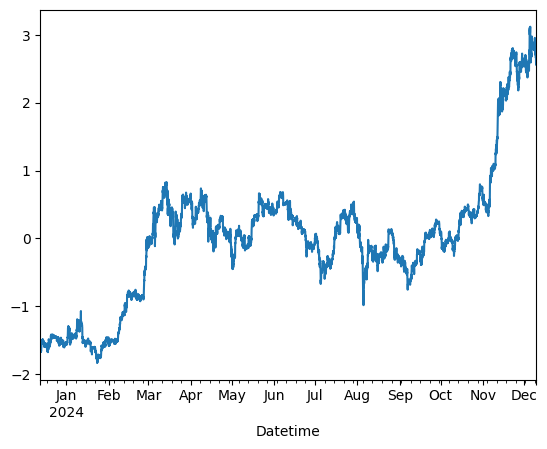

In [23]:
btc_df_norm.Close.plot()

In [24]:
# Разделим выборку на обучающую и тестовую, сформируем Target (0 - цена Close не выросла, 1 - выросла)

btc_df_features['Target'] = (btc_df_features['Close'].diff() > 0).astype(int)

In [25]:
btc_df_features[['Close', 'Target']]

,Close,Target
Datetime,,
2023-12-12 19:00:00+00:00,41099.148438,0
2023-12-12 20:00:00+00:00,41235.339844,1
2023-12-12 21:00:00+00:00,41062.550781,0
2023-12-12 22:00:00+00:00,41237.019531,1
2023-12-12 23:00:00+00:00,41471.710938,1
...,...,...
2024-12-09 19:00:00+00:00,97000.070312,0
2024-12-09 20:00:00+00:00,96149.820312,0
2024-12-09 21:00:00+00:00,97234.968750,1


In [26]:
# Разделим выборку на обучающую и тестовую

btc_df_features_train = btc_df_features.iloc[:-500, :]
btc_df_features_test = btc_df_features.iloc[-500:, :]

In [27]:
btc_df_features_train

,Adj Close,Close,High,Low,Open,Volume,Adj Close_lag_3,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Adj Close_lag_9,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_SMA_6,Close_SMA_20,Close_RSI_4,Close_RSI_9,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_20,Close_median_20,Close_min_20,Close_max_20,Close_std_20,Close_range_20,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_20,Close_roc_20,Month,Weekday,Hour,Target
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-12 19:00:00+00:00,41099.148438,41099.148438,41284.617188,41015.761719,41276.257812,0,41291.281250,41291.281250,41416.175781,41112.464844,41325.976562,0.000000e+00,41793.710938,41793.710938,41819.277344,41727.453125,41815.007812,0.000000e+00,41196.017578,41578.242969,41.061619,40.888058,41029.115885,41099.148438,40710.609375,41277.589844,289.905384,566.980469,41578.242969,41663.646484,40710.609375,42020.105469,319.013540,1309.496094,268.855469,0.995677,-0.004332,-192.132812,-0.465311,-148.757812,-0.360643,12,1,19,0
2023-12-12 20:00:00+00:00,41235.339844,41235.339844,41253.769531,41052.757812,41104.226562,0,40710.609375,40710.609375,41309.597656,40710.609375,41309.597656,6.823936e+07,41565.566406,41565.566406,41820.601562,41565.566406,41794.613281,0.000000e+00,41158.102214,41555.562891,48.929228,44.781267,41204.026042,41235.339844,41099.148438,41277.589844,93.251003,178.441406,41555.562891,41604.130859,40710.609375,42020.105469,326.759514,1309.496094,201.011719,1.003314,0.003308,524.730469,1.288928,-453.601562,-1.088062,12,1,20,1
2023-12-12 21:00:00+00:00,41062.550781,41062.550781,41331.257812,41031.664062,41223.996094,0,41277.589844,41277.589844,41361.023438,40667.562500,40667.562500,0.000000e+00,41845.718750,41845.718750,41903.785156,41576.035156,41576.035156,0.000000e+00,41112.753255,41526.555664,39.915721,40.933324,41132.346354,41099.148438,41062.550781,41235.339844,91.052684,172.789062,41526.555664,41556.398438,40710.609375,42020.105469,343.917395,1309.496094,299.593750,0.995810,-0.004199,-215.039062,-0.520958,-580.144531,-1.393148,12,1,21,0
2023-12-12 22:00:00+00:00,41237.019531,41237.019531,41265.882812,41072.421875,41083.824219,0,41099.148438,41099.148438,41284.617188,41015.761719,41276.257812,0.000000e+00,41793.671875,41793.671875,42002.500000,41763.589844,41845.265625,7.651738e+07,41103.709635,41495.378125,51.855852,46.186009,41178.303385,41235.339844,41062.550781,41237.019531,100.248214,174.468750,41495.378125,41505.031250,40710.609375,42020.105469,340.288494,1309.496094,193.460938,1.004249,0.004240,137.871094,0.335460,-623.550781,-1.489590,12,1,22,1
2023-12-12 23:00:00+00:00,41471.710938,41471.710938,41542.527344,41232.082031,41236.816406,238981120,41235.339844,41235.339844,41253.769531,41052.757812,41104.226562,0.000000e+00,41462.832031,41462.832031,41835.441406,41329.824219,41796.808594,0.000000e+00,41230.559896,41482.025391,64.506555,52.569116,41257.093750,41237.019531,41062.550781,41471.710938,205.317411,409.160156,41482.025391,41467.271484,40710.609375,42020.105469,335.440455,1309.496094,310.445312,1.005691,0.005675,236.371094,0.573225,-267.054688,-0.639824,12,1,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-18 23:00:00+00:00,90550.328125,90550.328125,91253.945312,90314.898438,91253.945312,344670208,91381.187500,91381.187500,91990.835938,90574.070312,90720.554688,3.671007e+09,90159.453125,90159.453125,90955.093750,89501.937500,89501.937500,2.142052e+09,90924.911458,91075.830859,35.054555,45.220769,91027.299479,91253.742188,90550.328125,91277.828125,413.244828,727.500000,91075.830859,91265.785156,89557.687500,92421.390625,732.243834,2863.703125,939.046875,0.992292,-0.007738,-830.859375,-0.909224,-91.640625,-0.101102,11,0,23,0
2024-11-19 00:00:00+00:00,91157.445312,91157.445312,91236.007812,9042

In [28]:
btc_df_features_test

,Adj Close,Close,High,Low,Open,Volume,Adj Close_lag_3,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Adj Close_lag_9,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_SMA_6,Close_SMA_20,Close_RSI_4,Close_RSI_9,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_20,Close_median_20,Close_min_20,Close_max_20,Close_std_20,Close_range_20,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_20,Close_roc_20,Month,Weekday,Hour,Target
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-19 04:00:00+00:00,91507.835938,91507.835938,91835.523438,91316.929688,91473.734375,789970944,90753.375000,90753.375000,91247.945312,90744.117188,91080.429688,0.000000e+00,90696.539062,90696.539062,90696.539062,89775.085938,90432.554688,2.310316e+09,91118.911458,91065.391016,63.616616,55.690537,91417.440104,91485.156250,91259.328125,91507.835938,137.397746,248.507812,91065.391016,91256.535156,89557.687500,92421.390625,678.829751,2863.703125,518.593750,1.000248,0.000248,754.460938,0.831331,-289.507812,-0.315377,11,1,4,1
2024-11-19 05:00:00+00:00,91830.367188,91830.367188,91841.679688,91298.789062,91555.539062,366297088,91259.328125,91259.328125,91298.148438,90761.687500,90761.687500,6.653542e+07,91381.187500,91381.187500,91990.835938,90574.070312,90720.554688,3.671007e+09,91332.251302,91070.239062,72.601337,59.360586,91607.786458,91507.835938,91485.156250,91830.367188,193.093832,345.210938,91070.239062,91256.535156,89557.687500,92421.390625,684.176836,2863.703125,542.890625,1.003525,0.003518,571.039062,0.625732,96.960938,0.105699,11,1,5,1
2024-11-19 06:00:00+00:00,92012.328125,92012.328125,92012.328125,91699.500000,91890.507812,0,91485.156250,91485.156250,91551.273438,91243.695312,91276.843750,2.957476e+08,91277.828125,91277.828125,92035.562500,91277.828125,91543.156250,1.077297e+09,91474.731771,91081.590625,76.893539,61.390282,91783.510417,91830.367188,91507.835938,92012.328125,255.489255,504.492188,91081.590625,91256.535156,89557.687500,92421.390625,698.400725,2863.703125,312.828125,1.001981,0.001980,527.171875,0.576238,227.031250,0.247350,11,1,6,1
2024-11-19 07:00:00+00:00,91684.140625,91684.140625,92016.070312,91684.140625,92010.007812,0,91507.835938,91507.835938,91835.523438,91316.929688,91473.734375,7.899709e+08,91253.742188,91253.742188,91523.671875,91150.320312,91369.257812,0.000000e+00,91629.859375,91152.701563,55.852192,55.741456,91842.278646,91830.367188,91684.140625,92012.328125,164.417672,328.187500,91152.701563,91268.578125,89557.687500,92421.390625,682.780007,2863.703125,331.929688,0.996433,-0.003573,176.304688,0.192666,1422.218750,1.575658,11,1,7,0
2024-11-19 08:00:00+00:00,91797.242188,91797.242188,91797.242188,91457.710938,91669.679688,0,91830.367188,91830.367188,91841.679688,91298.789062,91555.539062,3.662971e+08,90550.328125,90550.328125,91253.945312,90314.898438,91253.945312,3.446702e+08,91719.511719,91212.395312,60.783255,57.265971,91831.236979,91797.242188,91684.140625,92012.328125,166.713806,328.187500,91212.395312,91329.507812,89557.687500,92421.390625,684.412145,2863.703125,339.531250,1.001234,0.001233,-33.125000,-0.036072,1193.875000,1.317694,11,1,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-09 19:00:00+00:00,97000.070312,97000.070312,97779.671875,96980.539062,97779.671875,2891431936,97865.484375,97865.484375,98319.015625,97565.929688,97789.351562,3.983393e+09,98716.984375,98716.984375,98737.781250,98300.851562,98428.664062,1.803928e+09,98082.209635,98778.710938,28.842746,35.110089,97470.395833,97479.335938,97000.070312,97931.781250,465.919802,931.710938,98778.710938,98978.105469,97000.070312,100322.445312,854.965894,3322.375000,799.132812,0.990486,-0.009559,-865.414062,-0.884289,-4346.640625,-4.288882,12,0,19,0
2024-12-09 20:00:00+00:00,96149.820312,96149.820312,97236.070312,96146.

In [29]:
# Нормализуем Train

btc_df_features_train_norm, scaler_train = normalize_dataframe(btc_df_features_train, scaler_file='scaler_train.pkl')

In [30]:
btc_df_features_train_norm

,Adj Close,Close,High,Low,Open,Volume,Adj Close_lag_3,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Adj Close_lag_9,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_SMA_6,Close_SMA_20,Close_RSI_4,Close_RSI_9,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_20,Close_median_20,Close_min_20,Close_max_20,Close_std_20,Close_range_20,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_20,Close_roc_20,Month,Weekday,Hour,Target
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-12-12 19:00:00+00:00,-1.903967,-1.903967,-1.897274,-1.900230,-1.886713,-0.455949,-1.885257,-1.885257,-1.884525,-1.890781,-1.881868,-0.455897,-1.836331,-1.836331,-1.845516,-1.830564,-1.834236,-0.455384,-1.895577,-1.860824,-0.500782,-0.723202,-1.911298,-1.904443,-1.930869,-1.897945,0.472803,0.509607,-1.860824,-1.852593,-1.888089,-1.866369,-0.490379,-0.334143,-0.379794,-0.804002,-0.802681,-0.357012,-0.525458,-0.178896,-0.237400,1.767402,-1.001827,1.082743,-1.017309
2023-12-12 20:00:00+00:00,-1.890687,-1.890687,-1.900270,-1.896607,-1.903494,-0.455949,-1.941935,-1.941935,-1.894889,-1.930173,-1.883467,-0.366466,-1.858644,-1.858644,-1.845387,-1.846464,-1.836231,-0.455384,-1.899279,-1.863047,-0.126389,-0.458035,-1.894232,-1.891156,-1.892825,-1.897945,-0.516818,-0.514097,-1.863047,-1.858425,-1.888089,-1.866369,-0.470011,-0.334143,-0.583609,0.580408,0.581987,0.859296,1.322095,-0.381459,-0.534329,1.767402,-1.001827,1.227126,0.982985
2023-12-12 21:00:00+00:00,-1.907536,-1.907536,-1.892743,-1.898672,-1.891811,-0.455949,-1.886593,-1.886593,-1.889888,-1.934393,-1.946154,-0.455897,-1.831244,-1.831244,-1.837282,-1.845435,-1.857615,-0.455384,-1.903707,-1.865889,-0.555311,-0.720119,-1.901225,-1.904443,-1.896409,-1.902052,-0.527881,-0.528989,-1.865889,-1.863102,-1.888089,-1.866369,-0.424895,-0.334143,-0.287451,-0.779956,-0.778540,-0.395877,-0.584066,-0.465545,-0.658864,1.767402,-1.001827,1.371509,-1.017309
2023-12-12 22:00:00+00:00,-1.890523,-1.890523,-1.899094,-1.894681,-1.905484,-0.455949,-1.904011,-1.904011,-1.897318,-1.900261,-1.886723,-0.455897,-1.836335,-1.836335,-1.827663,-1.827014,-1.831276,-0.354947,-1.904590,-1.868945,0.012879,-0.362358,-1.896741,-1.891156,-1.896409,-1.901888,-0.481606,-0.524564,-1.868945,-1.868135,-1.888089,-1.866369,-0.434437,-0.334143,-0.606292,0.749931,0.750817,0.202909,0.317908,-0.494388,-0.698231,1.767402,-1.001827,1.515893,0.982985
2023-12-12 23:00:00+00:00,-1.867637,-1.867637,-1.872219,-1.879045,-1.890560,-0.142750,-1.890717,-1.890717,-1.900318,-1.896634,-1.903519,-0.455897,-1.868691,-1.868691,-1.843941,-1.869618,-1.836016,-0.455384,-1.892204,-1.870253,0.614883,0.072396,-1.889054,-1.890992,-1.896409,-1.879077,0.047132,0.093790,-1.870253,-1.871835,-1.888089,-1.866369,-0.447185,-0.334143,-0.254850,1.011420,1.010928,0.370035,0.568320,-0.257502,-0.351360,1.767402,-1.001827,1.660276,0.982985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-18 23:00:00+00:00,2.918248,2.918248,2.957076,2.927728,2.988351,-0.004239,3.003933,3.003933,3.033343,2.957735,2.940888,4.355114,2.893936,2.893936,2.942069,2.861745,2.831014,2.356274,2.960226,2.989801,-0.786638,-0.428101,2.967062,2.988905,2.949117,2.961946,1.093482,0.932536,2.989801,3.007868,2.966443,2.985314,0.596189,0.996242,1.633581,-1.417716,-1.419910,-1.440744,-0.992985,-0.140942,-0.131456,1.464264,-1.501828,1.660276,-1.017309
2024-11-19 00:00:00+00:00,2.977451,2.977451,2.955334,2.938796,2.913749,0.217526,2.993844,2.993844,3.037692,3.026721,3.021204,0.955947,3.115158,3.115158,3.095592,2.941993,2.910946,6.953931,2.972718,2.992956,0.107074,0.026467,2.963147,2.979510,2.949117,2.959605,0.933076,0.869075,2.992956,3.007868,2.966443,2.985314,0.564727,0.996242,1.240151,1.195145,1.193463,-0.235273,-0.174298,0.347805,0.200193,1.464264,-1.001827,-1.660540,0.982985
2024-11-19 01:00

In [31]:
# Загрузим сохраненный scaler на Train
scaler_test = load_scaler('scaler_train.pkl')

In [32]:
btc_df_features_test_norm, _ = normalize_dataframe(btc_df_features_test, scaler=scaler_test, save_scaler=False)

In [33]:
btc_df_features_test_norm

,Adj Close,Close,High,Low,Open,Volume,Adj Close_lag_3,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Adj Close_lag_9,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_SMA_6,Close_SMA_20,Close_RSI_4,Close_RSI_9,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_20,Close_median_20,Close_min_20,Close_max_20,Close_std_20,Close_range_20,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_20,Close_roc_20,Month,Weekday,Hour,Target
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-19 04:00:00+00:00,3.011619,3.011619,3.013575,3.025858,3.009791,0.579354,2.942653,2.942653,2.961104,2.974404,2.976025,-0.455897,2.946464,2.946464,2.916876,2.888573,2.922057,2.577136,2.979169,2.988778,0.572533,0.284996,3.005129,3.011483,3.018537,2.984302,-0.294659,-0.329489,2.988778,3.006961,2.966443,2.985314,0.455740,0.996242,0.370465,0.024623,0.027369,1.249082,0.840156,-0.272422,-0.218922,1.464264,-1.001827,-1.083006,0.982985
2024-11-19 05:00:00+00:00,3.043071,3.043071,3.014173,3.024082,3.017770,0.024105,2.992039,2.992039,2.965986,2.976126,2.944904,-0.368699,3.013424,3.013424,3.042987,2.967048,2.950232,4.363179,3.000001,2.989253,1.000086,0.534963,3.023701,3.013696,3.040649,3.015652,-0.014381,-0.074701,2.989253,3.006961,2.966443,2.985314,0.469800,0.996242,0.443457,0.618641,0.620077,0.937868,0.623621,-0.015620,-0.047041,1.464264,-1.001827,-0.938623,0.982985
2024-11-19 06:00:00+00:00,3.060815,3.060815,3.030750,3.063324,3.050445,-0.455949,3.014081,3.014081,2.990600,3.023375,2.995202,-0.068307,3.003316,3.003316,3.047345,3.036169,3.030708,0.958676,3.013914,2.990365,1.204337,0.673206,3.040846,3.045164,3.042870,3.033338,0.299611,0.344966,2.990365,3.006961,2.966443,2.985314,0.507201,0.996242,-0.247692,0.338894,0.341189,0.863439,0.571494,0.070810,0.010780,1.464264,-1.001827,-0.794240,0.982985
2024-11-19 07:00:00+00:00,3.028811,3.028811,3.031114,3.061820,3.062101,-0.455949,3.016295,3.016295,3.018240,3.030554,3.014426,0.579394,3.000960,3.000960,2.997469,3.023646,3.013696,-0.455384,3.029061,2.997334,0.203051,0.288464,3.046580,3.045164,3.060132,3.033338,-0.158687,-0.119553,2.997334,3.008142,2.966443,2.985314,0.466127,0.996242,-0.190308,-0.666918,-0.665099,0.268119,0.167519,0.864991,0.552990,1.464264,-1.001827,-0.649857,-1.017309
2024-11-19 08:00:00+00:00,3.039841,3.039841,3.009856,3.039645,3.028904,-0.455949,3.047777,3.047777,3.018839,3.028776,3.022413,0.024151,2.932165,2.932165,2.971188,2.941592,3.002414,-0.002970,3.037815,3.003184,0.437703,0.392299,3.045503,3.041932,3.060132,3.033338,-0.147133,-0.119553,3.003184,3.014112,2.966443,2.985314,0.470418,0.996242,-0.167471,0.203314,0.205869,-0.087222,-0.073387,0.713261,0.447690,1.464264,-1.001827,-0.505473,0.982985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-09 19:00:00+00:00,3.547193,3.547193,3.591028,3.580506,3.624902,3.333442,3.636854,3.636854,3.648693,3.643118,3.631066,4.764509,3.730880,3.730880,3.700381,3.725956,3.704323,1.912451,3.659104,3.744661,-1.082236,-1.116740,3.595720,3.596307,3.580634,3.608693,1.358558,1.470581,3.744661,3.763590,3.706084,3.745879,0.918881,1.388860,1.213254,-1.745032,-1.749963,-1.499373,-0.966724,-2.968317,-1.840889,1.767402,-1.501828,1.082743,-1.017309
2024-12-09 20:00:00+00:00,3.464281,3.464281,3.538219,3.498797,3.547943,6.100960,3.599163,3.599163,3.632146,3.634629,3.634346,2.354263,3.662905,3.662905,3.696855,3.698564,3.731024,1.872413,3.591198,3.727341,-1.467285,-1.456968,3.552479,3.549548,3.497383,3.608693,3.499146,3.710778,3.727341,3.747418,3.621584,3.745879,1.324622,2.116665,2.086719,-1.609356,-1.613080,-2.286818,-1.471841,-2.428876,-1.537649,1.767402,-1.501828,1.227126,-1.017309
2024-12-09 21:00:00+00:00,3.570099,3.570099,3.561386,3.390752,3.472801,13.894817,3.643325,3.643325,3.638015,3.622672,3.588887,3.118406,3.713944,3.713944,3.681482,3.69

<Axes: xlabel='Datetime'>

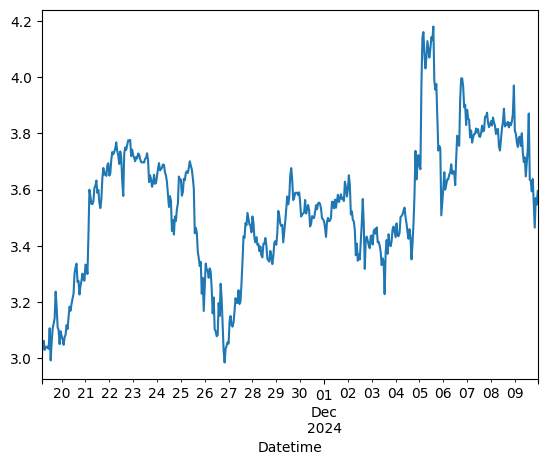

In [34]:
btc_df_features_test_norm.Close.plot()

<Axes: xlabel='Datetime'>

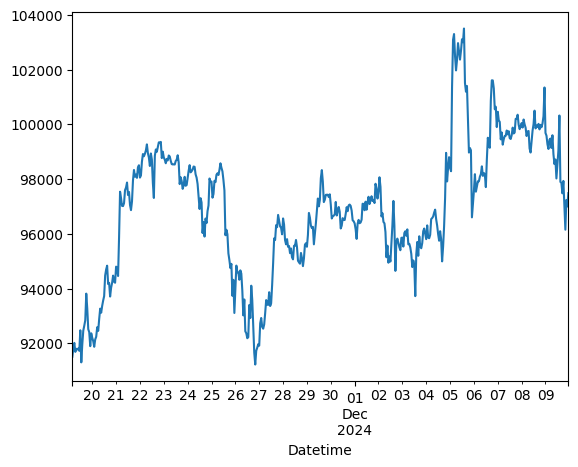

In [35]:
btc_df_features_test.Close.plot()

# Добавление новых данных (подготовка, сохранение)

In [188]:
import csv

def add_new_data(data, filename):
    """Функция для добавления новых данных в файл.

    Args:
        data (pd.Dataframe): датафрейм для добавления
        filename (str): имя файла с сохраненными данными, в него будут добавляться новые данные
    """

    # Создаем массивы для формирования фичей
    window_lag = []
    window_SMA = []
    window_RSI = []
    windows_stats = []
    windows_trend = []
    add_month=False, 
    add_weekday=False, 
    add_hour=False

    data_copy = data.copy()

    # Чтобы не сохранять в памяти весь файл, будем открывать и считывать по строкам
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        columns = next(reader) # получаем имена столбцов

        if 'Month' in columns:
            add_month = True
        if 'Weekday' in columns:
            add_weekday = True
        if 'Hour' in columns:
            add_hour = True

        for col in columns:
            # Вытаскиваем размеры окон для различных фичей и добавляем их в списки
            if 'lag' in col and 'Close' in col:
                window_lag.append(int(col.split('_')[-1]))
                window_lag = list(dict.fromkeys(window_lag)) # чтобы не было дубликатов
            if 'SMA' in col and 'Close' in col:
                window_SMA.append(int(col.split('_')[-1]))
                window_SMA = list(dict.fromkeys(window_SMA))
            if 'RSI' in col and 'Close' in col:
                window_RSI.append(int(col.split('_')[-1]))
                window_RSI = list(dict.fromkeys(window_RSI))
            if 'max' in col and 'Close' in col:
                windows_stats.append(int(col.split('_')[-1]))
                windows_stats = list(dict.fromkeys(windows_stats))
            if 'momentum' in col and 'Close' in col:
                windows_trend.append(int(col.split('_')[-1]))
                windows_trend = list(dict.fromkeys(windows_trend))
    
    # Получаем максимальное окно
    max_window = max([max(window_lag), max(window_SMA), max(window_RSI), max(windows_stats), max(windows_trend)])

    # Читаем последние n строк, используя скользящее окно
    last_n_rows = []
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            last_n_rows.append(row)
            if len(last_n_rows) > max_window + 1:  # Удаляем лишние строки
                last_n_rows.pop(0)

    df = pd.DataFrame(last_n_rows[1:], columns=columns).set_index('Datetime')  # last_n_rows[1:] Убираем заголовок из данных
    df.index = pd.to_datetime(df.index)
    data_for_prepare = pd.concat([df[data_copy.columns], data_copy], axis=0)
    data_for_prepare = data_for_prepare.apply(pd.to_numeric, errors='coerce')
    
    # добавляем фичи
    data_copy = prepare_date(
        data_for_prepare,
        lags=window_lag,
        windows_SMA=window_SMA,
        windows_RSI=window_RSI,
        windows_stats=windows_stats,
        windows_trend=windows_trend,
        add_month=add_month,
        add_weekday=add_weekday,
        add_hour=add_hour
    )

    append_new_data_to_csv(data_copy, filename, columns[0]) # записываем новые данные в файл
    

def append_new_data_to_csv(dataframe, csv_path, datetime_column):
    """Читаем CSV-файл и находим последнюю дату, добавляем только данные, которые по времени позже

    Args:
        dataframe ((pd.Dataframe): датафрейм для добавления
        csv_path (str): путь до файла/имя файла
        datetime_column (str): название колонки с датой-временем
    """
    try:
        # Читаем только столбец с датами, чтобы избежать чтения всего файла
        csv_data = pd.read_csv(csv_path, usecols=[datetime_column], parse_dates=[datetime_column])
        last_date = csv_data[datetime_column].max()  # Последняя дата в файле
    except FileNotFoundError:
        # Если файл не существует, добавляем весь DataFrame
        last_date = None
    
    # Фильтруем данные, оставляем только строки с датами > last_date
    if last_date:
        filtered_data = dataframe[dataframe.index > last_date]
    else:
        filtered_data = dataframe

    # Добавляем данные в CSV-файл
    if not filtered_data.empty:
        filtered_data.to_csv(csv_path, mode='a', header=not bool(last_date))  # Если файл пуст, добавляем заголовки
        print(f"Добавлено строк в файл: {len(filtered_data)}.")
    else:
        print("Нет новых данных для добавления.")

In [178]:
btc_df_add = yf.download("BTC-USD", start='2024-12-10', end='2024-12-11', interval='1h', multi_level_index=False)

[*********************100%***********************]  1 of 1 completed


In [137]:
btc_df_add

,Adj Close,Close,High,Low,Open,Volume
Datetime,,,,,,
2024-12-10 00:00:00+00:00,97888.015625,97888.015625,98115.531250,97080.914062,97391.328125,0
2024-12-10 01:00:00+00:00,98014.242188,98014.242188,98088.281250,97603.757812,97891.539062,665968640
2024-12-10 02:00:00+00:00,96904.148438,96904.148438,97991.656250,96904.148438,97991.656250,444170240
2024-12-10 03:00:00+00:00,96785.578125,96785.578125,96963.257812,95795.140625,96773.492188,3627892736
2024-12-10 04:00:00+00:00,97073.507812,97073.507812,97097.500000,96069.750000,96962.148438,994238464
2024-12-10 05:00:00+00:00,96963.789062,96963.789062,97072.312500,96585.414062,97072.312500,1043906560
2024-12-10 06:00:00+00:00,97448.765625,97448.765625,97453.859375,96907.328125,96969.914062,648577024
2024-12-10 07:00:00+00:00,97210.414062,97210.414062,97473.234375,96944.062500,97473.234375,0
2024-12-10 08:00:00+00:00,97476.171875,97476.171875,97498.843750,97044.429688,97216.984375,0


In [ ]:
add_new_data(btc_df_add.iloc[1:2], 'data_btc_with_features.csv')
#add_new_data(btc_df_add, 'data_btc_with_features.csv')

Обнаружены дубликаты по индексу. Они будут удалены.
Пропущенные значения отсутствуют.
Нет новых данных для добавления.
